In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_forecasting.data import MultiNormalizer,GroupNormalizer
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
pool_data = pd.read_csv('PoolData.csv',on_bad_lines='skip')

In [3]:
# take a look at the data
pool_data.head()

,date,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
0,1708041600,-1.134062e+08,-1.134397e+08,-40444.288855,-1.340651e+06,6112,71218.096220
1,1708128000,-2.021456e+07,-2.022691e+07,-6543.765972,2.032085e+06,5318,61110.814054
2,1708214400,1.004206e+07,1.007014e+07,2807.137887,3.506131e+06,5947,66131.846264
3,1708300800,1.042544e+08,1.042212e+08,34278.399880,1.366455e+06,6827,118259.065975
4,1708387200,3.163059e+07,3.164884e+07,9927.220991,5.582752e+06,7136,134074.363181


In [4]:
# get some general information about the data
pool_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                990 non-null    int64  
 1   volumeUSDChange     990 non-null    float64
 2   volumeToken0Change  990 non-null    float64
 3   volumeToken1Change  990 non-null    float64
 4   tvlUSDChange        990 non-null    float64
 5   txCount             990 non-null    int64  
 6   feesUSD             990 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 54.3 KB


In [5]:
# get more statistical information about the data
pool_data.describe()

,date,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
count,9.900000e+02,9.900000e+02,9.900000e+02,9.900000e+02,9.900000e+02,990.000000,9.900000e+02
mean,1.712275e+09,4.886174e+05,3.172368e+05,1.098578e+05,3.886413e+05,1698.201010,6.078784e+04
std,2.470334e+06,7.328615e+07,6.627237e+07,2.944746e+07,1.031125e+07,2326.680401,9.994701e+04
min,1.708042e+09,-7.469638e+08,-7.463939e+08,-3.500031e+08,-8.136680e+07,6.000000,3.321232e+00
25%,1.710115e+09,-1.179282e+07,-1.906429e+06,-2.686228e+05,-1.062848e+06,248.250000,3.824943e+03
50%,1.712275e+09,-2.034204e+05,-4.715822e+01,-3.309524e+02,1.211091e+03,745.500000,2.861033e+04
75%,1.714435e+09,1.202061e+07,7.393220e+05,3.479959e+04,1.546306e+06,1385.750000,8.214568e+04
max,1.716509e+09,7.683531e+08,7.676765e+08,2.720772e+08,9.420977e+07,10561.000000,1.781509e+06


In [6]:
# convert the date time from seconds
pool_data['date'] = pd.to_datetime(pool_data.date, unit='s')

In [7]:
# get some general information about the data
pool_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                990 non-null    datetime64[ns]
 1   volumeUSDChange     990 non-null    float64       
 2   volumeToken0Change  990 non-null    float64       
 3   volumeToken1Change  990 non-null    float64       
 4   tvlUSDChange        990 non-null    float64       
 5   txCount             990 non-null    int64         
 6   feesUSD             990 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 54.3 KB


In [8]:
# get more statistical information about the data
pool_data.describe()

,date,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
count,990,9.900000e+02,9.900000e+02,9.900000e+02,9.900000e+02,990.000000,9.900000e+02
mean,2024-04-05 00:00:00,4.886174e+05,3.172368e+05,1.098578e+05,3.886413e+05,1698.201010,6.078784e+04
min,2024-02-16 00:00:00,-7.469638e+08,-7.463939e+08,-3.500031e+08,-8.136680e+07,6.000000,3.321232e+00
25%,2024-03-11 00:00:00,-1.179282e+07,-1.906429e+06,-2.686228e+05,-1.062848e+06,248.250000,3.824943e+03
50%,2024-04-05 00:00:00,-2.034204e+05,-4.715822e+01,-3.309524e+02,1.211091e+03,745.500000,2.861033e+04
75%,2024-04-30 00:00:00,1.202061e+07,7.393220e+05,3.479959e+04,1.546306e+06,1385.750000,8.214568e+04
max,2024-05-24 00:00:00,7.683531e+08,7.676765e+08,2.720772e+08,9.420977e+07,10561.000000,1.781509e+06
std,NaN,7.328615e+07,6.627237e+07,2.944746e+07,1.031125e+07,2326.680401,9.994701e+04


In [9]:
# convert the date time from seconds
pool_data['date'] = pd.to_datetime(pool_data.date, unit='s')

/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


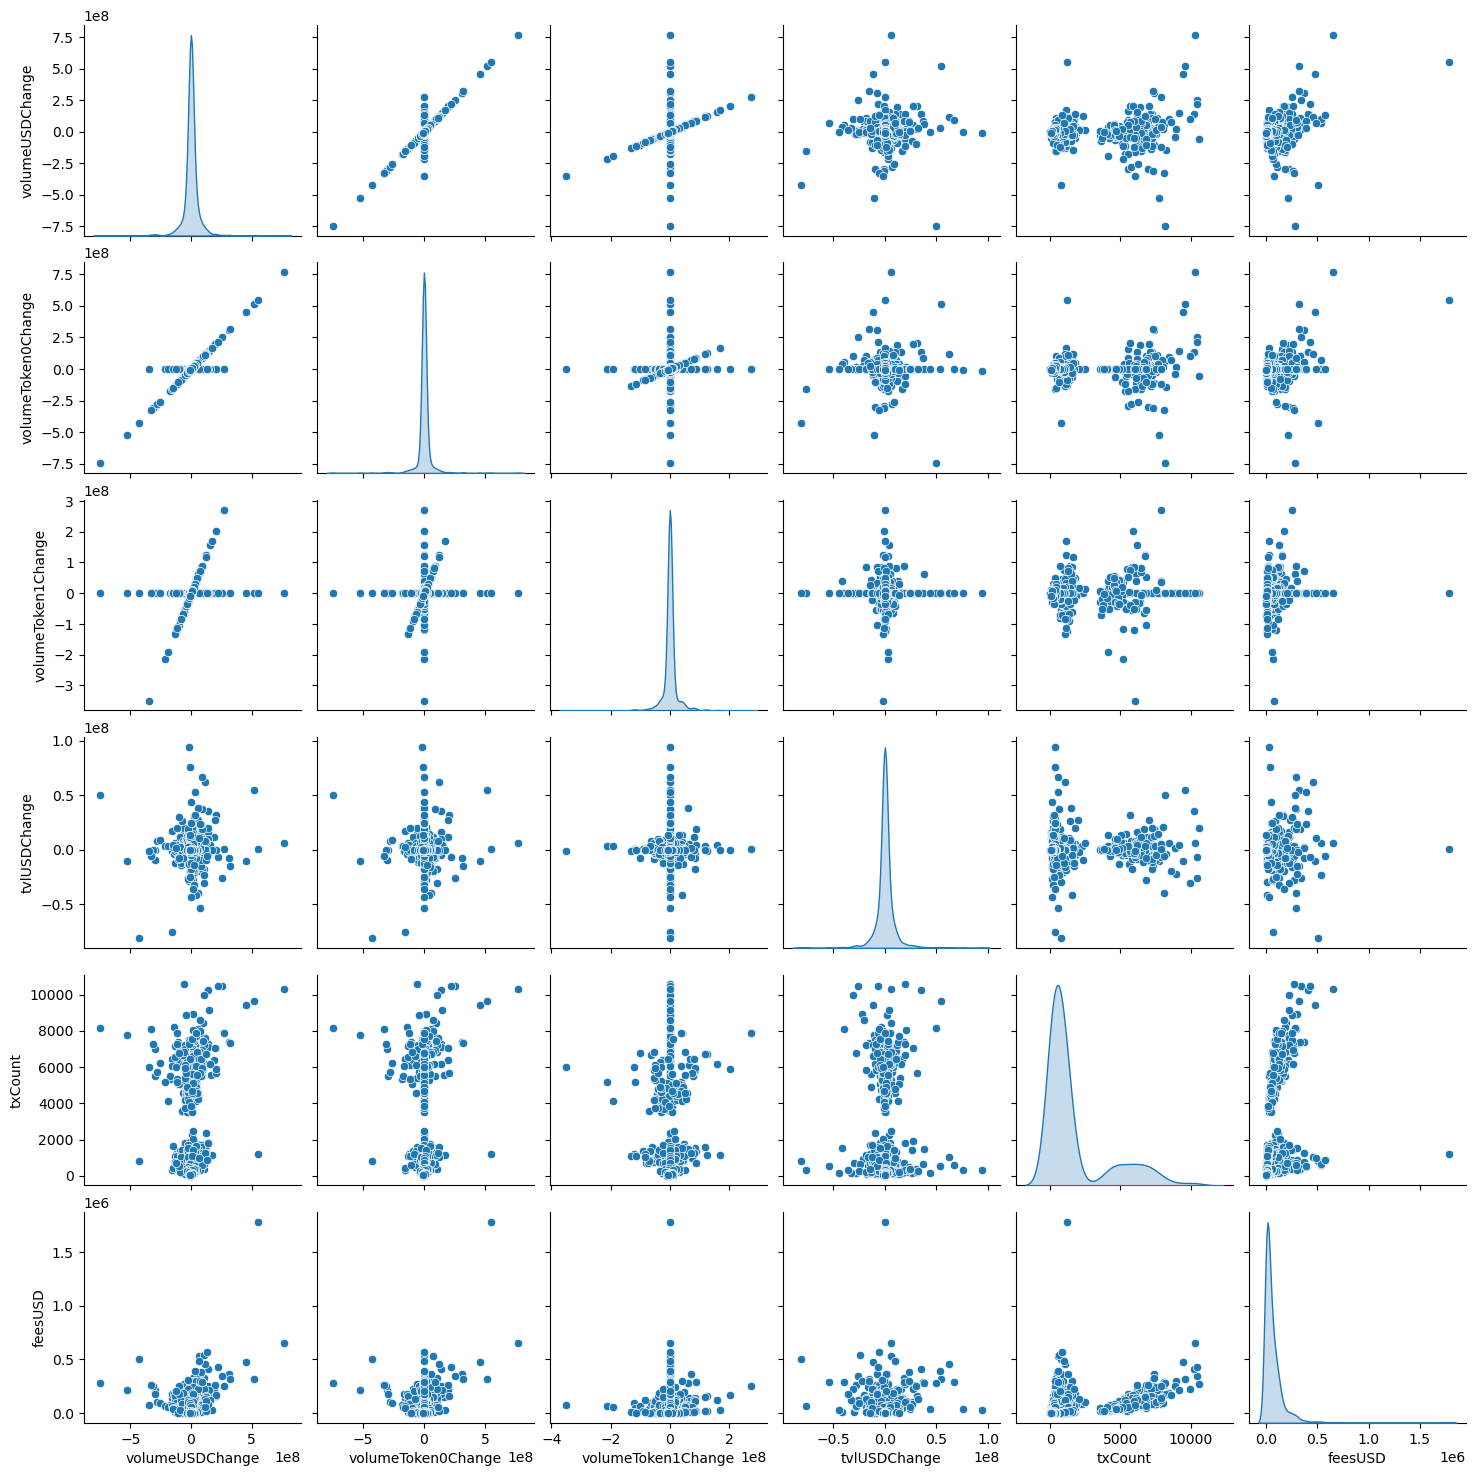

In [10]:
sns.pairplot(pool_data,kind='scatter',diag_kind='kde')

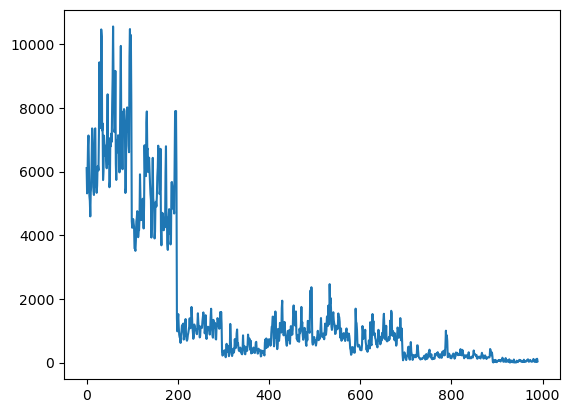

In [11]:
plt.plot(pool_data.index,pool_data[['txCount']],)

<Axes: >

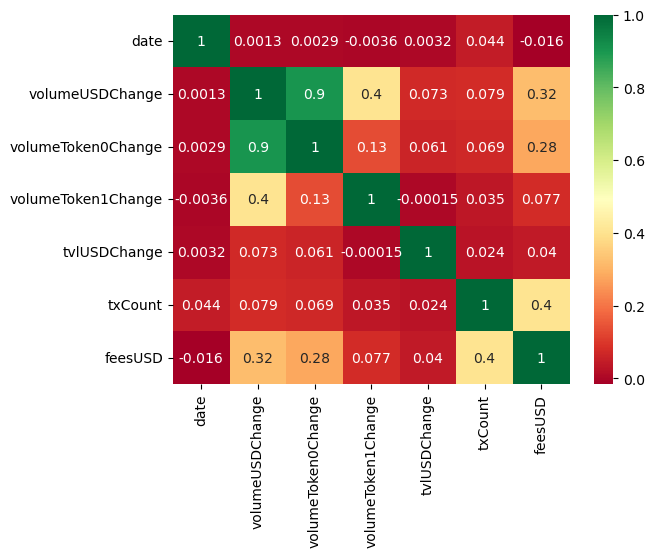

In [12]:
# get a correlation heatmap 
sns.heatmap(pool_data.corr(),cmap="RdYlGn",annot=True)

In [13]:
# create a new data frame using the last two
df_in = pool_data.drop('date',axis=1)

df_out = df_in[['txCount','feesUSD']]

In [14]:
df_out.head()

,txCount,feesUSD
0,6112,71218.096220
1,5318,61110.814054
2,5947,66131.846264
3,6827,118259.065975
4,7136,134074.363181


In [15]:
df_in.head()

,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
0,-1.134062e+08,-1.134397e+08,-40444.288855,-1.340651e+06,6112,71218.096220
1,-2.021456e+07,-2.022691e+07,-6543.765972,2.032085e+06,5318,61110.814054
2,1.004206e+07,1.007014e+07,2807.137887,3.506131e+06,5947,66131.846264
3,1.042544e+08,1.042212e+08,34278.399880,1.366455e+06,6827,118259.065975
4,3.163059e+07,3.164884e+07,9927.220991,5.582752e+06,7136,134074.363181


In [16]:
# scaled the data
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()
# txCount = df.txCount.values.reshape(-1,1)
scaled_df_in = scaler_in.fit_transform(df_in)
scaled_df_out = scaler_out.fit_transform(df_out)

In [17]:
sequence_length = 60

In [18]:
# Function to split the data into sequences
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

In [19]:
def get_train_test_sets_x(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    x_test = sequences[n_train:, :-1, :]
    return x_train, x_test

In [20]:
def get_train_test_sets_y(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    # select the last two columns for y
    y_train = sequences[:n_train, -1, -2:]
    # select the last two columns for y
    y_test = sequences[n_train:, -1, -2:]
    return y_train, y_test

In [21]:
sequences_x = split_into_sequences(scaled_df_in,sequence_length)
sequences_y = split_into_sequences(scaled_df_out,sequence_length)

In [22]:
print(f'sequence x shape is {sequences_x.shape}')
print(f'sequence y shape is {sequences_y.shape}')
# print(f'Sample {sequences[0]}')

sequence x shape is (931, 60, 6)
sequence y shape is (931, 60, 2)


In [23]:
x_train, x_test = get_train_test_sets_x(scaled_df_in, sequence_length, train_frac=0.9)
y_train, y_test = get_train_test_sets_y(scaled_df_out, sequence_length, train_frac=0.9)

In [24]:
# print the shapes
print(f"x_train shape is {x_train.shape}")
print(f"y_train shape is {y_train.shape}")
print(f"x_test shape is {x_test.shape}")
print(f"y_test shape is {y_test.shape}")

x_train shape is (837, 59, 6)
y_train shape is (837, 2)
x_test shape is (94, 59, 6)
y_test shape is (94, 2)


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size,hidden_size, num_layers,dropout):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size*2, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_size*4, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size*2, output_size)
        self.activation = nn.Identity()  # Linear activation
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout(x)
        
        x = self.linear(x[:, -1, :])
        x = self.activation(x)
        return x

# Hyperparameters
input_size = x_train.shape[-1]
hidden_size = sequence_length - 1
output_size = 2
num_layers = 1
dropout = 0.2

# Initialize the model
model = LSTMModel(input_size,output_size,hidden_size, num_layers, dropout)

/home/terungwa/anaconda3/envs/ubase/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [26]:
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Prepare the data
x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))

# test
x_test_tensor = torch.from_numpy(x_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))
x_test_tensor.dtype

torch.float32

In [28]:
# Training parameters
batch_size = 16
epochs = 10

In [29]:
train_indices =  list(range(len(x_train_tensor)))
val_indices =  list(range(len(x_test_tensor)))

In [30]:

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

In [31]:
# combine the x,y tensors into one dataset
#Training data
train_dataset = torch.utils.data.TensorDataset(x_train_tensor,y_train_tensor)
# Validation data
val_dataset = torch.utils.data.TensorDataset(x_test_tensor,y_test_tensor)

In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,sampler=val_sampler)

In [33]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        output = model(x_batch)
        # loss = criterion(output, y_train_tensor[train_sampler.indices])
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}')

Epoch 1/10, Validation Loss: 0.0003
Epoch 2/10, Validation Loss: 0.0001
Epoch 3/10, Validation Loss: 0.0005


Epoch 4/10, Validation Loss: 0.0020
Epoch 5/10, Validation Loss: 0.0014
Epoch 6/10, Validation Loss: 0.0006
Epoch 7/10, Validation Loss: 0.0008
Epoch 8/10, Validation Loss: 0.0004
Epoch 9/10, Validation Loss: 0.0009
Epoch 10/10, Validation Loss: 0.0013


In [34]:
# set the model to evaluation mode
model.eval()
# move the data to gpu
x_test_tensor = x_test_tensor.to(device)
# run the evaluation
y_pred = model(x_test_tensor)
# copy the prediction from cpu to gpu
y_pred = y_pred.cpu().detach().numpy()
# invert the scaler to get the absolute price data
y_test_orig = scaler_out.inverse_transform(y_test)
y_pred_orig = scaler_out.inverse_transform(y_pred)


In [35]:
y_pred_orig.shape

(94, 2)

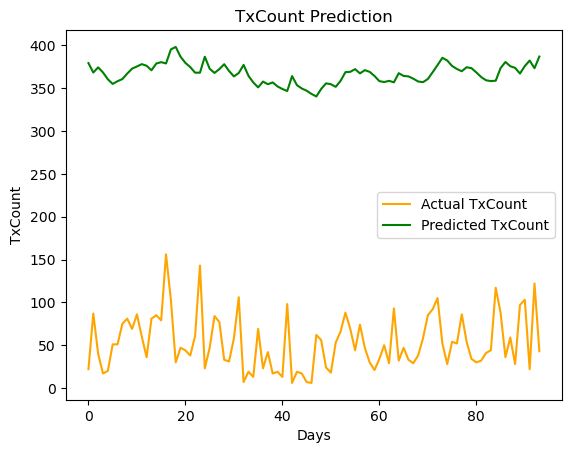

In [36]:


# plots of prediction against actual data
plt.plot(y_test_orig[:,0], label='Actual TxCount', color='orange')
plt.plot(y_pred_orig[:,0], label='Predicted TxCount', color='green')
 
plt.title('TxCount Prediction')
plt.xlabel('Days')
plt.ylabel('TxCount')
plt.legend(loc='best')

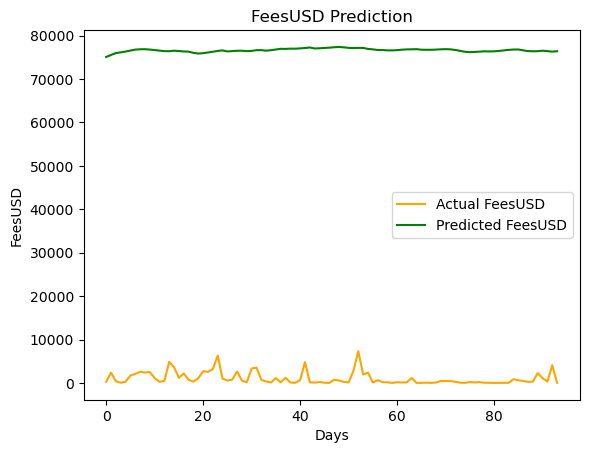

In [37]:
# plots of prediction against actual data
plt.plot(y_test_orig[:,1], label='Actual FeesUSD', color='orange')
plt.plot(y_pred_orig[:,1], label='Predicted FeesUSD', color='green')
 
plt.title('FeesUSD Prediction')
plt.xlabel('Days')
plt.ylabel('FeesUSD')
plt.legend(loc='best')

In [39]:
# save the model
torch.save(model,'pool_data_txCount_feesUSD_model_6.pth')